# Examine Clusters

This notebook is for examining clusters generated by the second step of the analysis (phase 2). The clustering algorithm will be applied to the data and plots will be displayed showing the results. This is useful for tuning the various clustering parameters. Note that data generated here is NOT saved. This is only for testing. 

First we import all the things

In [1505]:
import sys
sys.path.append('..')
from pcutils.core.config import load_config
from pcutils.core.workspace import Workspace
from pcutils.core.point_cloud import PointCloud
from pcutils.core.clusterize import clusterize, join_clusters, cleanup_clusters
import h5py as h5
import matplotlib.pyplot as plt
import numpy.random as random
import numpy as np

Now we'll load the point clouds generated by phase one. This is very similar to the previous example where we loaded traces, so please reference that section if anything is unclear.

First load the config and the workspace

In [1506]:
config = load_config('../config.json')
# Tweak some parameters
# config.trace.peak_threshold = 1

# Create our workspace
ws = Workspace(config.workspace)

Now use the workspace to load the point cloud file

In [1507]:
run_number = 4
point_file = h5.File(ws.get_point_cloud_file_path(run_number), 'r')

cloud_group: h5.Group = point_file.get('cloud')
min_event = cloud_group.attrs['min_event']
max_event = cloud_group.attrs['max_event']

Now load a random cloud from the file

In [1508]:
event = random.randint(min_event, max_event)
event_data = cloud_group[f'cloud_{event}']
cloud = PointCloud()
cloud.load_cloud_from_hdf5_data(event_data[:].copy(), event)

### Analysis

Now that we have our cloud were ready to cluster! The first step returns a list of clusters identified by the algorithm.

In [1509]:
clusters = clusterize(cloud, config.cluster)

We can then plot the clusters together to check the performance of the algorithm

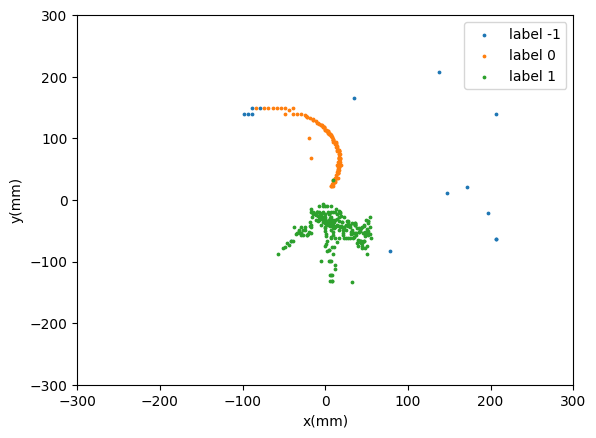

In [1510]:
for cluster in clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 0], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.xlim(-300.0, 300.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

Above shows the x-y projection. Below are several other projections over which the clustering is performed. Typically this first stage will identify a whole bunch of cluster chunks, due to the varying density of trajectory points. So we need to join together these clusters into larger clusters

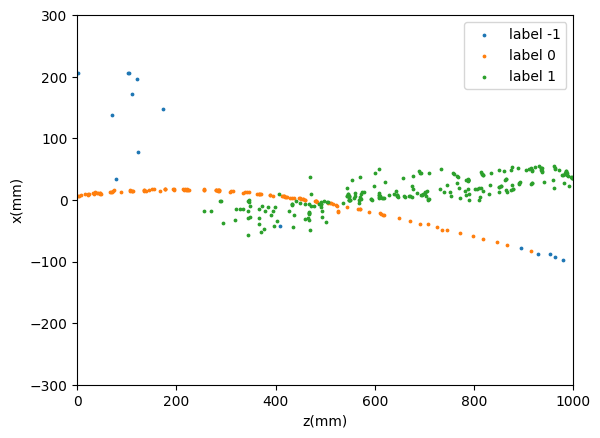

In [1511]:
for cluster in clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 0], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('x(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

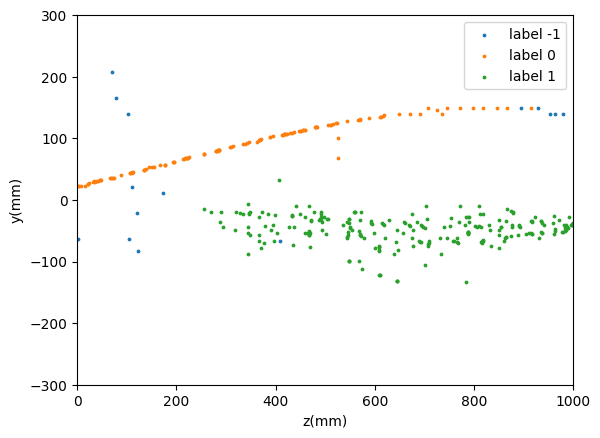

In [1512]:
for cluster in clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('y(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

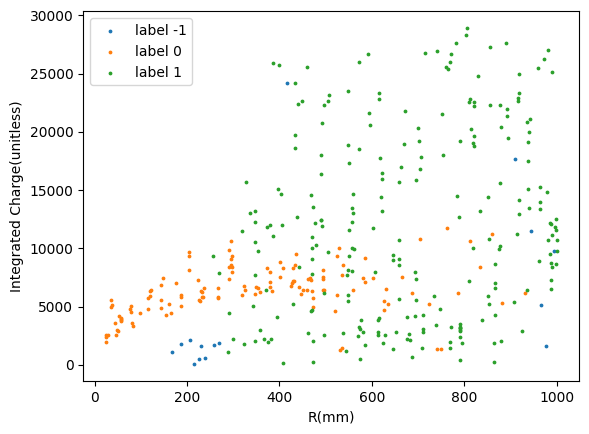

In [1513]:
for cluster in clusters:
    plt.scatter(np.linalg.norm(cluster.point_cloud.cloud[:, :3], axis=1), cluster.point_cloud.cloud[:, 4], s=3, label=f'label {cluster.label}')
plt.xlabel('R(mm)')
plt.ylabel('Integrated Charge(unitless)')
plt.legend()
plt.show()

Now we join the clusters!

In [1514]:
joined_clusters = join_clusters(clusters, config.cluster)

Now we can again plot our clusters

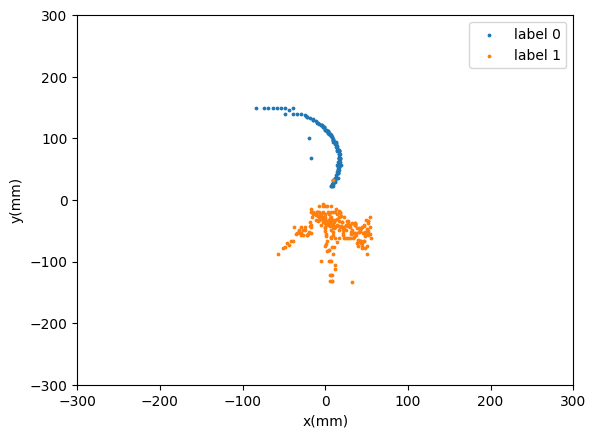

In [1515]:
for cluster in joined_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 0], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.xlim(-300.0, 300.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

Now you should see well defined trajectory clusters! If you don't, try tweaking some of the parameters or cycling to a different point cloud. Some additional projections are shown below for the joined clusters.

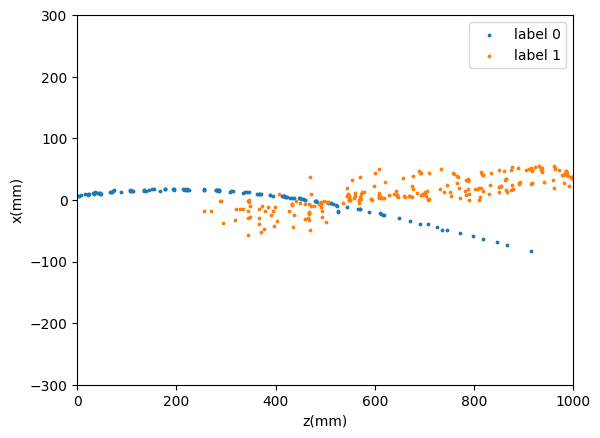

In [1516]:
for cluster in joined_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 0], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('x(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

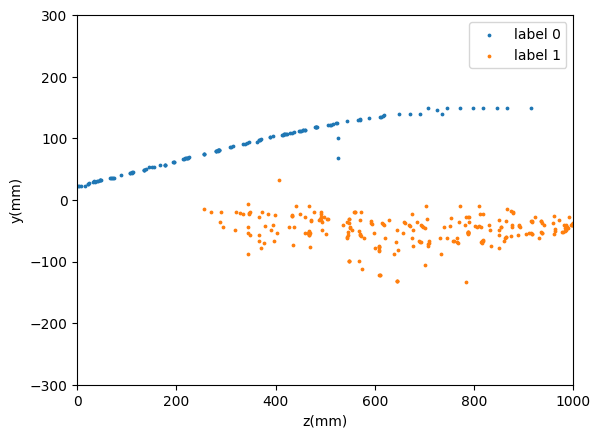

In [1517]:
for cluster in joined_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('y(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

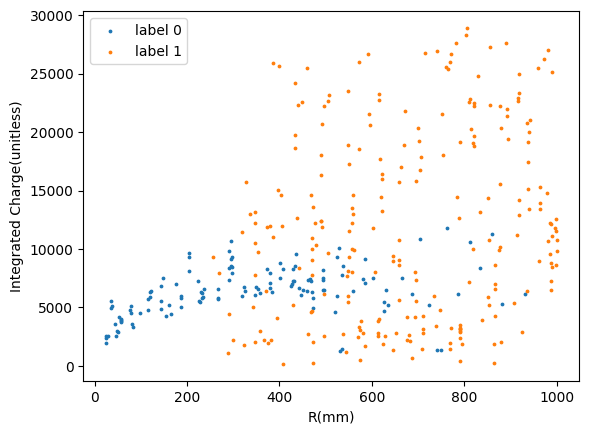

In [1518]:
for cluster in joined_clusters:
    plt.scatter(np.linalg.norm(cluster.point_cloud.cloud[:, :3], axis=1), cluster.point_cloud.cloud[:, 4], s=3, label=f'label {cluster.label}')
plt.xlabel('R(mm)')
plt.ylabel('Integrated Charge(unitless)')
plt.legend()
plt.show()

Finally, a cleanup pass is run on the joined clusters to reduce noise and smooth the trajectory

In [1519]:
cleaned_clusters = cleanup_clusters(joined_clusters, config.cluster)

We can again plot our projections to examine the results

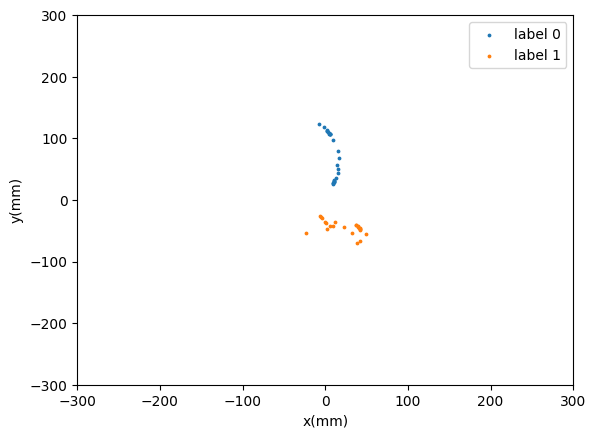

In [1520]:
for cluster in cleaned_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 0], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('x(mm)')
plt.ylabel('y(mm)')
plt.xlim(-300.0, 300.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

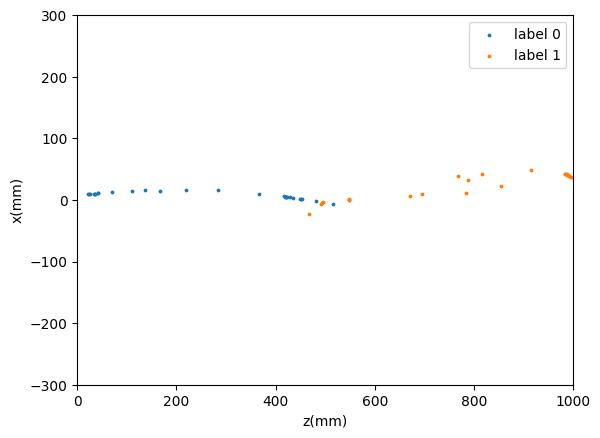

In [1521]:
for cluster in cleaned_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 0], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('x(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

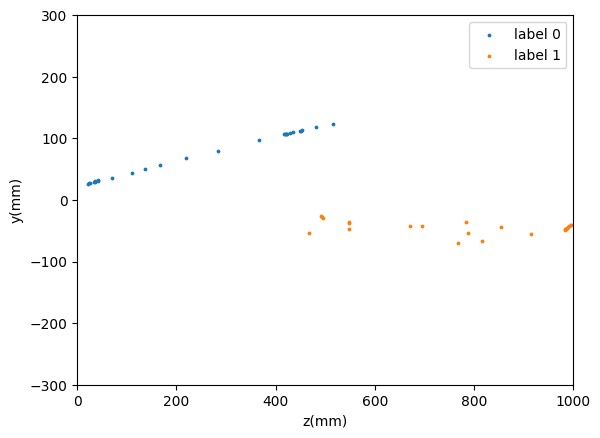

In [1522]:
for cluster in cleaned_clusters:
    plt.scatter(cluster.point_cloud.cloud[:, 2], cluster.point_cloud.cloud[:, 1], s=3, label=f'label {cluster.label}')
plt.xlabel('z(mm)')
plt.ylabel('y(mm)')
plt.xlim(0.0, 1000.0)
plt.ylim(-300.0, 300.0)
plt.legend()
plt.show()

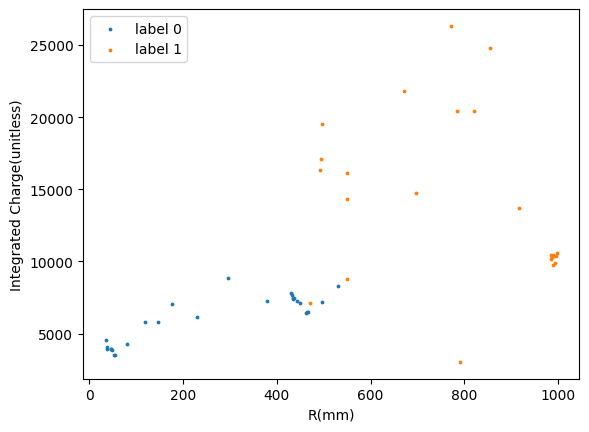

In [1523]:
for cluster in cleaned_clusters:
    plt.scatter(np.linalg.norm(cluster.point_cloud.cloud[:, :3], axis=1), cluster.point_cloud.cloud[:, 4], s=3, label=f'label {cluster.label}')
plt.xlabel('R(mm)')
plt.ylabel('Integrated Charge(unitless)')
plt.legend()
plt.show()

### Conclusion

We've now generated clusters from our point clouds and tested the parameters, so now you can take these parameters and run the full phase 2 analysis. The next step is perfom basic physics analysis and estimate some pararameters (phase 3).